In [1]:
import pandas as pd
import scanpy as sc

In [2]:
adata = sc.read_h5ad("integrated_scRNA.h5ad")

In [3]:
Conserved_markers = pd.read_excel("Conserved_gene.xlsx", index_col=0)

### Figure 4D

In [4]:
# Make a copy of the original AnnData object
adata2 = adata.copy()
adata2.var.index = adata2.var.index.str.replace("_", "-")

# Add a new 'Annotation2' column to the observations (obs) dataframe, copying values from 'Annotation'
adata2.obs['Annotation2'] = adata2.obs.Annotation

# List of specific cell types to keep
cells_to_keep = ['vil.Hofb', 'HB', 'M_fs_Macro', 'Macro_2']

# Replace cell types not in 'cells_to_keep' with 'other_cells'
adata2.obs['Annotation2'] = adata2.obs['Annotation2'].apply(
    lambda x: x if x in cells_to_keep else 'other_cells'
)

adata2.obs['Annotation2'].unique()


array(['other_cells', 'HB', 'vil.Hofb', 'M_fs_Macro', 'Macro_2'],
      dtype=object)

In [5]:
sc.pp.normalize_total(adata2)
# Logarithmize the data
sc.pp.log1p(adata2)

In [6]:
adata2.obs['Annotation2'] = pd.Categorical(
    adata2.obs['Annotation2'],
    categories=['HB', 'vil.Hofb', 'M_fs_Macro', 'Macro_2', 'other_cells'],
    ordered=True
)

In [7]:
adata2 = adata2[~adata2.obs.Status.str.contains("Health")]

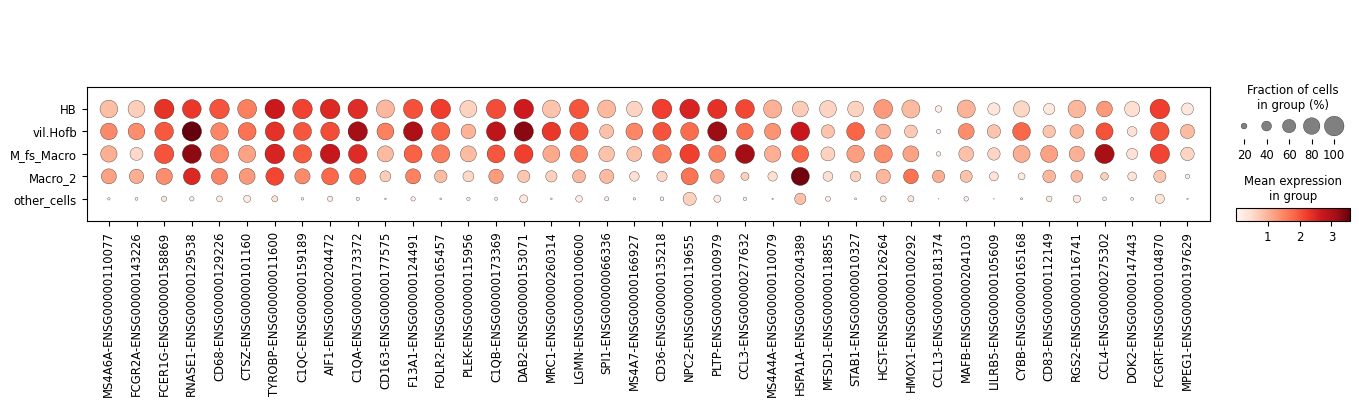

In [8]:
import matplotlib.pyplot as plt
import scanpy as sc

# Set rcParams to ensure text is editable in PDF
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

# Generate the dot plot and return the figure
dotplot = sc.pl.dotplot(
    adata2, 
    Conserved_markers.sort_values("max_pval", ascending=True).index.tolist()[:40], 
    groupby='Annotation2', 
    return_fig=True  )
    
dotplot.show()

### Modules were generated using the Gephi tool based on conserved genes

In [9]:
module_genes = pd.read_excel("Module_table.xlsx", index_col=1).iloc[:,1:]

In [10]:
module_genes

,Label,modularity_class,X,Y,Size,Color,ENSEM
Unnamed: 0,,,,,,,
LYVE1_ENSG00000133800,LYVE1,A,26.665518,-13.279196,10,#ee7993,ENSG00000133800
F13A1_ENSG00000124491,F13A1,A,-28.709587,-1.283960,10,#ee7993,ENSG00000124491
FOLR2_ENSG00000165457,FOLR2,A,98.792931,101.810081,10,#ee7993,ENSG00000165457
C1QC_ENSG00000159189,C1QC,A,105.773705,56.785320,10,#ee7993,ENSG00000159189
LY96_ENSG00000154589,LY96,A,218.635696,-27.194592,10,#ee7993,ENSG00000154589
...,...,...,...,...,...,...,...
CXCL2_ENSG00000081041,CXCL2,B,100.812714,-339.876373,10,#3fb17d,ENSG00000081041
GNA13_ENSG00000120063,GNA13,B,-335.964203,-237.312851,10,#3fb17d,ENSG00000120063
PLEKHB2_ENSG00000115762,PLEKHB2,B,-19.514687,-415.588989,10,#3fb17d,ENSG00000115762


In [20]:
### Adult skin scRNA-seq data
adult_adata = sc.read_h5ad("Adults_healthy_AD.h5ad")

In [21]:
Macro_2 = adult_adata[adult_adata.obs.final_clustering =='Macro_2']

In [22]:
sc.pp.normalize_total(Macro_2)
# Logarithmize the data
sc.pp.log1p(Macro_2)

/home/yang/anaconda3/lib/python3.11/site-packages/scanpy/preprocessing/_normalization.py:206: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


### Calculate module scores

In [26]:
modul_A = module_genes[module_genes.modularity_class == 'A']
modul_B = module_genes[module_genes.modularity_class == 'B']

In [27]:
gene_list = modul_A.Label.tolist()
sc.tl.score_genes(Macro_2, gene_list, score_name='Module_A')


gene_list = modul_B.Label.tolist()
sc.tl.score_genes(Macro_2, gene_list, score_name='Module_B')

### Figure 4g

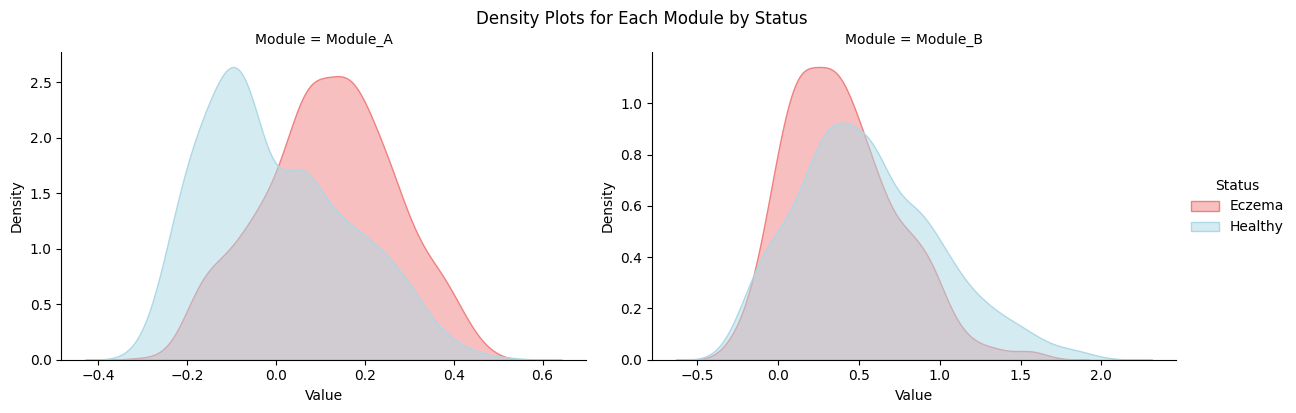

In [28]:
density = Macro_2.obs.loc[:,['Status','Module_A','Module_B']]

import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

density = pd.DataFrame(density)

df_long = density.melt(id_vars='Status', var_name='Module', value_name='Value')


palette = {"Healthy": "lightblue", "Eczema": "lightcoral"}


g = sns.FacetGrid(df_long, col="Module", hue="Status", palette=palette, sharex=False, sharey=False, height=4, aspect=1.5)
g.map(sns.kdeplot, "Value", fill=True, alpha=0.5).add_legend()

g.fig.suptitle('Density Plots for Each Module by Status', y=1.02)

plt.show()


### GSEA plot (figure 4f)

In [18]:
# Read placenta bulk transcriptome files
Pla_gene = pd.read_csv("Placenta_gene_exp.txt", index_col=0)

In [19]:
import gseapy as gp
gene_sets = {
    "Module_A": modul_A.Label.tolist(),
    "Module_B": modul_B.Label.tolist()
}


In [20]:
gsea_input = Pla_gene[Pla_gene.Group.str.contains("G3|G4")] # G4 = PM high AD, G3 = PM high healthy

gsea_input = gsea_input.sort_values("Group", ascending=False)

phenoA, phenoB, class_vector  = gp.parser.gsea_cls_parser(gsea_input.Group)

In [21]:
gs = gp.gsea(
        data=gsea_input.iloc[:,:-1].T,  # GSEA input data
        gene_sets=gene_sets,  # Gene set library
        cls=class_vector,  # Class vector
        permutation_num=500,  # Number of permutations
        outdir=None,  # Do not write output to disk
        method='signal_to_noise',  # Scoring method
        threads=40#  Set seed for reproducibility 
)

/home/yang/anaconda3/lib/python3.11/site-packages/gseapy/gsea.py:110: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  df_std = df.groupby(by=cls_dict, axis=1).std(numeric_only=True, ddof=0)


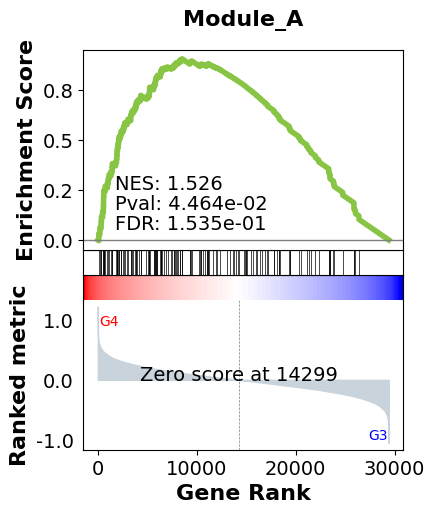

In [22]:
import matplotlib.pyplot as plt

terms = gs.res2d.Term
gs.plot(terms[0])

plt.show()
